# Chicago Water Lead Levels Anatomization


## Install libraries:

In [1]:
%pip install --upgrade pip
%pip install seaborn
%pip install openpyxl
%pip install python-Levenshtein
%pip install pandas
%pip install numpy
%pip install geopandas
%pip install uszipcode
%pip install altair
%pip install seaborn
%pip install openpyxl
%pip install levenshtein

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Libraries:

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from uszipcode import SearchEngine
import altair as alt
import json
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings

## Load Dataset:
Load lead data set
Load street data set containing street direction location by Chicago grid address  
Load GeoJson file with Chicago neighborhood boundaries

In [3]:
df = pd.read_excel('lead.xlsx',skiprows=2,dtype={'Address': str, '1st Draw': str, '2/3 Min': str, '5 Min': str})
gdf = chicagogdf = gpd.read_file("boundaries-zipcode.geojson")
df_streets = pd.read_csv('Streets.csv')
zip_df = pd.read_csv('uszips.csv')

Replace X to 0

In [4]:
for i,row in df.iterrows():
    addr = row['Address']
    addr_l = addr.split()
    addr_l[0] = addr_l[0].replace('X','0')
    fixed_addr = ' '.join(addr_l)
    df.loc[i, 'Address'] = fixed_addr
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min
0,2019-10-16 00:00:00,100000 S OAKLEY AVE,3,10,9.6
1,2019-02-23 00:00:00,10000 S ARTESIAN AVE,9.2,4.3,2.5
2,2019-05-03 00:00:00,10000 S ARTESIAN AVE,1.1,2.9,1.3
3,2019-05-05 00:00:00,10000 S ARTESIAN AVE,1.2,2.6,< 1
4,2021-11-30 09:00:00,10000 S AVENUE L,3.6,16,4.6
...,...,...,...,...,...
40051,2020-02-19 00:00:00,00 W SCHILLER ST,4.1,3.6,1.2
40052,2020-11-01 00:00:00,00 W SCHILLER ST,< 1,< 1,< 1
40053,2022-10-26 07:04:00,00 W SCHILLER ST,<0.5,<0.5,<0.5
40054,2023-05-23 08:15:00,00 W SCHILLER ST,1,1.3,0.6


Remove invalid row

In [5]:
df = df[df['1st Draw'].notna()]
df = df[df['2/3 Min'].notna()]
df = df[df['5 Min'].notna()]
df = df[df['1st Draw'] != ' ']
df = df[df['5 Min'] != ' ']
df = df[df['2/3 Min'] != ' ']
df = df[df['1st Draw'] != '']
df = df[df['5 Min'] != '']
df = df[df['2/3 Min'] != '']
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min
0,2019-10-16 00:00:00,100000 S OAKLEY AVE,3,10,9.6
1,2019-02-23 00:00:00,10000 S ARTESIAN AVE,9.2,4.3,2.5
2,2019-05-03 00:00:00,10000 S ARTESIAN AVE,1.1,2.9,1.3
3,2019-05-05 00:00:00,10000 S ARTESIAN AVE,1.2,2.6,< 1
4,2021-11-30 09:00:00,10000 S AVENUE L,3.6,16,4.6
...,...,...,...,...,...
40051,2020-02-19 00:00:00,00 W SCHILLER ST,4.1,3.6,1.2
40052,2020-11-01 00:00:00,00 W SCHILLER ST,< 1,< 1,< 1
40053,2022-10-26 07:04:00,00 W SCHILLER ST,<0.5,<0.5,<0.5
40054,2023-05-23 08:15:00,00 W SCHILLER ST,1,1.3,0.6


remove '<' symbol

In [6]:
cols = ['1st Draw', '2/3 Min', '5 Min']
df[cols] = df[cols].applymap(lambda x: x.replace('<', '').strip() if isinstance(x, str) else x)
df['1st Draw'] = df['1st Draw'].astype(float)
df['2/3 Min'] = df['2/3 Min'].astype(float)
df['5 Min'] = df['5 Min'].astype(float)
df = df.sort_values('Sample Date', ascending=True).reset_index(drop=True)

df.to_csv('lead_cleaned.csv')
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00
...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50


In [7]:
df.columns

Index(['Sample Date', 'Address', '1st Draw', '2/3 Min', '5 Min'], dtype='object')

In [8]:
df.describe

<bound method NDFrame.describe of               Sample Date               Address  1st Draw  2/3 Min  5 Min
0     2016-01-27 00:00:00   3800 S CAMPBELL AVE      1.54     1.00   1.00
1     2016-01-27 00:00:00   4500 N MERRIMAC AVE      3.22     2.17   1.94
2     2016-01-29 00:00:00   2500 N ST LOUIS AVE     19.10     1.89   1.66
3     2016-01-29 00:00:00  2500 N ST LOUIS AVE*     19.10     1.89   1.66
4     2016-01-29 00:00:00    6100 S LANGLEY AVE      1.00     1.00   1.00
...                   ...                   ...       ...      ...    ...
37313 2023-08-25 16:00:00  4900 W KAMERLING AVE      3.60     7.60   3.30
37314 2023-08-27 08:21:00       1400 N NOBLE ST      0.50     0.50   0.50
37315 2023-08-27 09:33:00      800 N PAULINA ST      0.50     0.50   0.50
37316 2023-08-28 07:00:00   1700 N PARKSIDE AVE      0.50     0.50   0.50
37317 2023-08-28 09:00:00      5200 W NELSON ST      1.60     0.50   0.60

[37318 rows x 5 columns]>

In [9]:
gdf.columns

Index(['objectid', 'shape_area', 'shape_len', 'zip', 'geometry'], dtype='object')

In [10]:
gdf.head()

,objectid,shape_area,shape_len,zip,geometry
0,33,106052287.488,42720.0444058,60647,"MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ..."
1,34,127476050.762,48103.7827213,60639,"MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ..."
2,35,45069038.4783,27288.6096123,60707,"MULTIPOLYGON (((-87.78500 41.90915, -87.78531 ..."
3,36,70853834.3797,42527.9896789,60622,"MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ..."
4,37,99039621.2518,47970.1401531,60651,"MULTIPOLYGON (((-87.70656 41.89555, -87.70672 ..."


extract address number into a new column. will be used to get coordinates

In [11]:
# Replace 'XX' with '00', then replace 'X' with '0', and extract street numbers
df['Address Num'] = df['Address'].str.replace('XX', '00').str.replace('X', '0').str.extract(r'(\d+)').fillna(0).astype(int)

df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100
...,...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700


In [12]:
# Extract the direction (N, S, E, W) from the 'Address' column
df['Address Dir'] = df['Address'].str.extract(r'\s([NSEW])\s')
# If the 'Address Dir' column contains any NaN values, fill them with an empty string
df['Address Dir'].fillna('', inplace=True)
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S
...,...,...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N


extract street name for joining later on

In [13]:
# Extract the street name from the 'Address' column
df['Street Name'] = df['Address'].str.extract(r'[NSEW]\s(.+)$')
# Remove the asterisk (*) at the end of street names
df['Street Name'] = df['Street Name'].str.replace(r'\*$', '', regex=True)

df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE
...,...,...,...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE


add and fill coordinate columns (Lat, Lon)  
if the address direction is N or S, then add the Address Num to Lat  
if the address direction is E or W, then add the Address Num to Lon


In [14]:
# Add 'Lat' column
df['Lat'] = df.apply(lambda row: int(row['Address Num']) if 'N' in row['Address Dir'] or 'S' in row['Address Dir'] else None, axis=1)

# Add 'Lon' column
df['Lon'] = df.apply(lambda row: int(row['Address Num']) if 'E' in row['Address Dir'] or 'W' in row['Address Dir'] else None, axis=1)
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,NaN
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,NaN
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,NaN
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,NaN
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,NaN
...,...,...,...,...,...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,NaN,4900.0
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,NaN
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,NaN
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,NaN


In [15]:
df_streets.columns

Index(['Name', 'Street Dir', 'Street Num'], dtype='object')

In [16]:
df.columns

Index(['Sample Date', 'Address', '1st Draw', '2/3 Min', '5 Min', 'Address Num',
       'Address Dir', 'Street Name', 'Lat', 'Lon'],
      dtype='object')

make sure all street names are upper case before joining

In [17]:
df['Street Name'] = df['Street Name'].str.upper()
df_streets['Name'] = df_streets['Name'].str.upper()



In [18]:
merged_df = pd.merge(df, df_streets, left_on='Street Name', right_on='Name', how='left')


In [19]:
merged_df


,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,NaN,CAMPBELL AVE,W,2500.0
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,NaN,MERRIMAC AVE,W,6234.0
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,NaN,ST LOUIS AVE,W,3500.0
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,NaN,ST LOUIS AVE,W,3500.0
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,NaN,LANGLEY AVE,E,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,NaN,4900.0,KAMERLING AVE,N,1332.0
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,NaN,NOBLE ST,W,1400.0
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,NaN,PAULINA ST,W,1700.0
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,NaN,PARKSIDE AVE,W,5632.0


inspect any rows in the data frame

In [20]:
merged_df.iloc[20000:20010]


,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num
20000,2019-11-19,100 E DELAWARE PL,1.0,1.0,1.0,100,E,DELAWARE PL,NaN,100.0,DELAWARE PL,N,900.0
20001,2019-11-19,1900 N NEVA AVE,1.0,1.0,1.0,1900,N,NEVA AVE,1900.0,NaN,NEVA AVE,W,7132.0
20002,2019-11-19,2000 N LARRABEE ST,1.9,1.9,1.0,2000,N,LARRABEE ST,2000.0,NaN,LARRABEE ST,W,600.0
20003,2019-11-19,8400 S LUELLA AVE,1.7,1.1,1.0,8400,S,LUELLA AVE,8400.0,NaN,LUELLA AVE,E,2232.0
20004,2019-11-19,3400 W 76TH PL,4.1,1.5,1.2,3400,W,76TH PL,NaN,3400.0,76TH PL,S,7632.0
20005,2019-11-19,5900 N NEVA AVE,2.0,1.1,1.1,5900,N,NEVA AVE,5900.0,NaN,NEVA AVE,W,7132.0
20006,2019-11-19,3800 W VAN BUREN ST,1.8,4.2,2.7,3800,W,VAN BUREN ST,NaN,3800.0,VAN BUREN ST,S,400.0
20007,2019-11-19,3700 W 114TH PL,14.0,2.7,2.9,3700,W,114TH PL,NaN,3700.0,114TH PL,S,11432.0
20008,2019-11-19,5800 W CORNELIA AVE,1.6,2.0,2.6,5800,W,CORNELIA AVE,NaN,5800.0,CORNELIA AVE,N,3500.0
20009,2019-11-19,900 N KEYSTONE AVE,1.0,1.0,1.0,900,N,KEYSTONE AVE,900.0,NaN,KEYSTONE AVE,W,4032.0


put the street number in the corresponding coordinate (Lat or Lon) 

In [21]:
merged_df['Lat'] = np.where(merged_df['Street Dir'].isin(['N', 'S']), merged_df['Street Num'], merged_df['Lat'])
merged_df['Lon'] = np.where(merged_df['Street Dir'].isin(['E', 'W']), merged_df['Street Num'], merged_df['Lon'])


inspect

In [22]:
merged_df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,2500.0,CAMPBELL AVE,W,2500.0
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,6234.0,MERRIMAC AVE,W,6234.0
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,700.0,LANGLEY AVE,E,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,1332.0,4900.0,KAMERLING AVE,N,1332.0
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,1400.0,NOBLE ST,W,1400.0
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,1700.0,PAULINA ST,W,1700.0
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,5632.0,PARKSIDE AVE,W,5632.0


In [23]:
merged_df.iloc[20000:20010]

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num
20000,2019-11-19,100 E DELAWARE PL,1.0,1.0,1.0,100,E,DELAWARE PL,900.0,100.0,DELAWARE PL,N,900.0
20001,2019-11-19,1900 N NEVA AVE,1.0,1.0,1.0,1900,N,NEVA AVE,1900.0,7132.0,NEVA AVE,W,7132.0
20002,2019-11-19,2000 N LARRABEE ST,1.9,1.9,1.0,2000,N,LARRABEE ST,2000.0,600.0,LARRABEE ST,W,600.0
20003,2019-11-19,8400 S LUELLA AVE,1.7,1.1,1.0,8400,S,LUELLA AVE,8400.0,2232.0,LUELLA AVE,E,2232.0
20004,2019-11-19,3400 W 76TH PL,4.1,1.5,1.2,3400,W,76TH PL,7632.0,3400.0,76TH PL,S,7632.0
20005,2019-11-19,5900 N NEVA AVE,2.0,1.1,1.1,5900,N,NEVA AVE,5900.0,7132.0,NEVA AVE,W,7132.0
20006,2019-11-19,3800 W VAN BUREN ST,1.8,4.2,2.7,3800,W,VAN BUREN ST,400.0,3800.0,VAN BUREN ST,S,400.0
20007,2019-11-19,3700 W 114TH PL,14.0,2.7,2.9,3700,W,114TH PL,11432.0,3700.0,114TH PL,S,11432.0
20008,2019-11-19,5800 W CORNELIA AVE,1.6,2.0,2.6,5800,W,CORNELIA AVE,3500.0,5800.0,CORNELIA AVE,N,3500.0
20009,2019-11-19,900 N KEYSTONE AVE,1.0,1.0,1.0,900,N,KEYSTONE AVE,900.0,4032.0,KEYSTONE AVE,W,4032.0


we now have the city grid locations. we need to convert to gps coordinates  

In [24]:
base_lat = 41.8820500120278
base_lon = -87.62782737167875
# lat_factor = 0.0000174041
# lon_factor = 0.0000248416
lat_factor_N = 0.00001818932
lat_factor_S = 0.00001687716
lon_factor_E = 0.00002430679
lon_factor_W = 0.00002456658

# Create 'Lat GPS' column with computed values
merged_df['Lat GPS'] = np.where(
    (merged_df['Street Dir'].isin(['N']) | merged_df['Address Dir'].isin(['N'])),
    base_lat + merged_df['Lat'] * lat_factor_N, merged_df['Lat']
)
merged_df['Lat GPS'] = np.where(
    (merged_df['Street Dir'].isin(['S']) | merged_df['Address Dir'].isin(['S'])),
    base_lat - merged_df['Lat'] * lat_factor_S, merged_df['Lat GPS']
)

# Create 'Lon GPS' column with computed values
merged_df['Lon GPS'] = np.where(
    (merged_df['Street Dir'].isin(['E']) | merged_df['Address Dir'].isin(['E'])),
    base_lon + merged_df['Lon'] * lon_factor_E, merged_df['Lon']
)
merged_df['Lon GPS'] = np.where(
    (merged_df['Street Dir'].isin(['W']) | merged_df['Address Dir'].isin(['W'])),
    base_lon - merged_df['Lon'] * lon_factor_W, merged_df['Lon GPS']
)



In [25]:
merged_df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num,Lat GPS,Lon GPS
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,2500.0,CAMPBELL AVE,W,2500.0,41.817917,-87.689244
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,6234.0,MERRIMAC AVE,W,6234.0,41.963902,-87.780975
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,700.0,LANGLEY AVE,E,700.0,41.779099,-87.610813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,1332.0,4900.0,KAMERLING AVE,N,1332.0,41.906278,-87.748204
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,1400.0,NOBLE ST,W,1400.0,41.907515,-87.662221
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,1700.0,PAULINA ST,W,1700.0,41.896601,-87.669591
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,5632.0,PARKSIDE AVE,W,5632.0,41.912972,-87.766186


In [26]:
merged_df.iloc[20000:20010]

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num,Lat GPS,Lon GPS
20000,2019-11-19,100 E DELAWARE PL,1.0,1.0,1.0,100,E,DELAWARE PL,900.0,100.0,DELAWARE PL,N,900.0,41.898420,-87.625397
20001,2019-11-19,1900 N NEVA AVE,1.0,1.0,1.0,1900,N,NEVA AVE,1900.0,7132.0,NEVA AVE,W,7132.0,41.916610,-87.803036
20002,2019-11-19,2000 N LARRABEE ST,1.9,1.9,1.0,2000,N,LARRABEE ST,2000.0,600.0,LARRABEE ST,W,600.0,41.918429,-87.642567
20003,2019-11-19,8400 S LUELLA AVE,1.7,1.1,1.0,8400,S,LUELLA AVE,8400.0,2232.0,LUELLA AVE,E,2232.0,41.740282,-87.573575
20004,2019-11-19,3400 W 76TH PL,4.1,1.5,1.2,3400,W,76TH PL,7632.0,3400.0,76TH PL,S,7632.0,41.753244,-87.711354
20005,2019-11-19,5900 N NEVA AVE,2.0,1.1,1.1,5900,N,NEVA AVE,5900.0,7132.0,NEVA AVE,W,7132.0,41.989367,-87.803036
20006,2019-11-19,3800 W VAN BUREN ST,1.8,4.2,2.7,3800,W,VAN BUREN ST,400.0,3800.0,VAN BUREN ST,S,400.0,41.875299,-87.721180
20007,2019-11-19,3700 W 114TH PL,14.0,2.7,2.9,3700,W,114TH PL,11432.0,3700.0,114TH PL,S,11432.0,41.689110,-87.718724
20008,2019-11-19,5800 W CORNELIA AVE,1.6,2.0,2.6,5800,W,CORNELIA AVE,3500.0,5800.0,CORNELIA AVE,N,3500.0,41.945713,-87.770314
20009,2019-11-19,900 N KEYSTONE AVE,1.0,1.0,1.0,900,N,KEYSTONE AVE,900.0,4032.0,KEYSTONE AVE,W,4032.0,41.898420,-87.726880


In [27]:
gdf.columns

Index(['objectid', 'shape_area', 'shape_len', 'zip', 'geometry'], dtype='object')

the dataset is now ready to be plotted on the geojson shape file

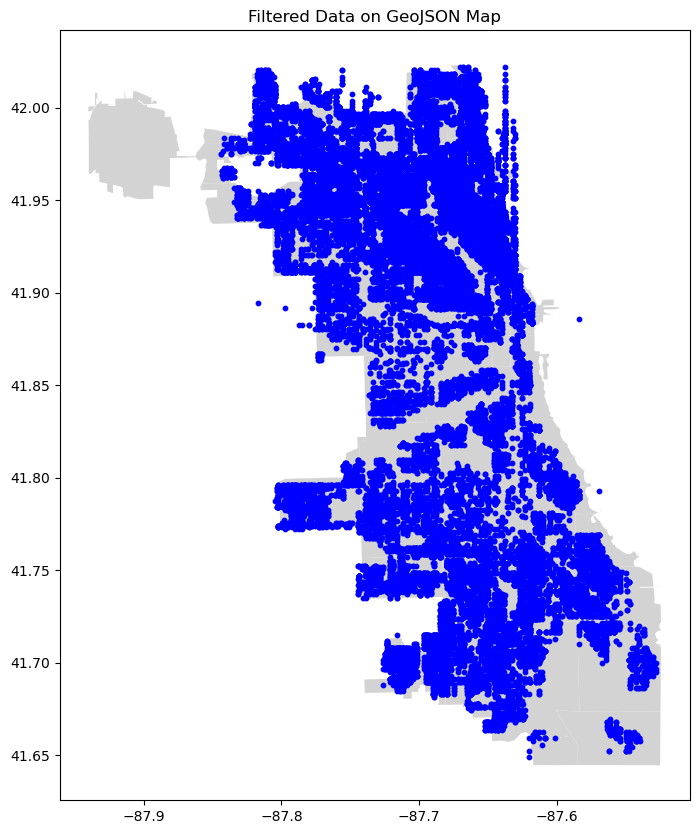

In [28]:
# Define bounding box (min_lon, min_lat, max_lon, max_lat)
bounding_box = (-87.90, 41.50, -87.50, 42.08)  # Example bounding box
# Filter the DataFrame to include only points within the bounding box
filtered_df = merged_df[
    (merged_df['Lon GPS'] >= bounding_box[0]) &
    (merged_df['Lon GPS'] <= bounding_box[2]) &
    (merged_df['Lat GPS'] >= bounding_box[1]) &
    (merged_df['Lat GPS'] <= bounding_box[3])
]
# Create a GeoDataFrame from the filtered DataFrame
gdf = gpd.GeoDataFrame(
    filtered_df,
    geometry=gpd.points_from_xy(filtered_df['Lon GPS'], filtered_df['Lat GPS']),
    crs="EPSG:4326"
)
# Read the GeoJSON file into a GeoDataFrame
geojson_file = "boundaries-zipcode.geojson"
geojson_gdf = gpd.read_file(geojson_file)
# Plot the GeoJSON data and the filtered points
ax = geojson_gdf.plot(color='lightgray', figsize=(10, 10))
gdf.plot(ax=ax, color='blue', markersize=10)
plt.title("Filtered Data on GeoJSON Map")
plt.show()

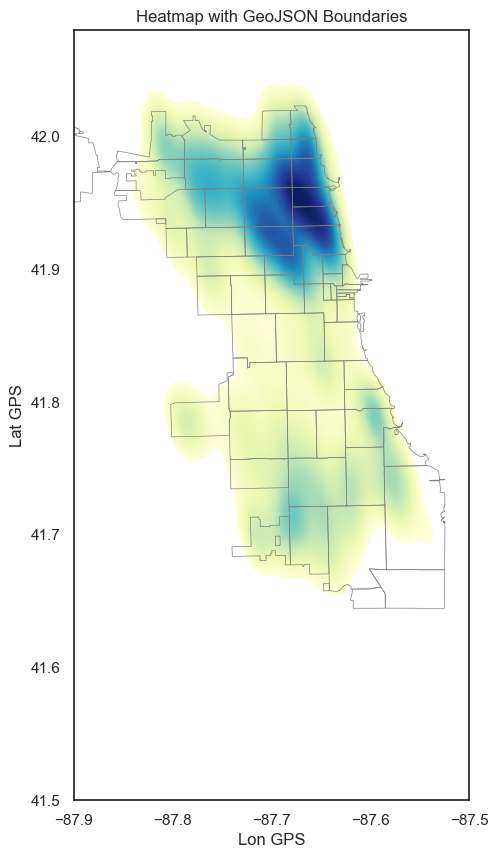

In [29]:

# Define your bounding box (min_lon, min_lat, max_lon, max_lat)
bounding_box = (-87.90, 41.50, -87.50, 42.08)  # Example bounding box
# Filter the DataFrame to include only points within the bounding box
filtered_df = merged_df[
    (merged_df['Lon GPS'] >= bounding_box[0]) &
    (merged_df['Lon GPS'] <= bounding_box[2]) &
    (merged_df['Lat GPS'] >= bounding_box[1]) &
    (merged_df['Lat GPS'] <= bounding_box[3])
]
# Create a GeoDataFrame from the filtered DataFrame
gdf = gpd.GeoDataFrame(
    filtered_df,
    geometry=gpd.points_from_xy(filtered_df['Lon GPS'], filtered_df['Lat GPS']),
    crs="EPSG:4326"
)
# Create a heatmap
sns.set(style="white")
plt.figure(figsize=(10, 10))
sns.kdeplot(data=gdf, x="Lon GPS", y="Lat GPS", fill=True, cmap="YlGnBu", levels=100)
# Read the GeoJSON file into a GeoDataFrame
geojson_file = "boundaries-zipcode.geojson"
geojson_gdf = gpd.read_file(geojson_file)
# Plot the GeoJSON data on top of the heatmap
ax = geojson_gdf.plot(ax=plt.gca(), color='none', edgecolor='gray', linewidth=0.5)
ax.set_xlim(bounding_box[0], bounding_box[2])
ax.set_ylim(bounding_box[1], bounding_box[3])
plt.title("Heatmap with GeoJSON Boundaries")
plt.show()

In [30]:
gdf.columns

Index(['Sample Date', 'Address', '1st Draw', '2/3 Min', '5 Min', 'Address Num',
       'Address Dir', 'Street Name', 'Lat', 'Lon', 'Name', 'Street Dir',
       'Street Num', 'Lat GPS', 'Lon GPS', 'geometry'],
      dtype='object')

In [31]:
search = SearchEngine(db_file_path="./tmp/zipcodes.sqlite") 

In [32]:
def get_zip_code(latitude, longitude):
    '''This function turns Latitude and Longitude into zipcodes'''
    #print(latitude,longitude)
    try:
        z = search.by_coordinates(lat = latitude,lng =  longitude, radius = 5, returns = 1)
        return z[0].to_dict()['zipcode']
    except:
        z = "error"
        return z
     #access the zipcode from information object


#Add zipcode column to cameras_sorted 
#this will take like 5 mins to run make sure you have python levenshtein installed https://pypi.org/project/python-Levenshtein/
merged_df['zip'] = merged_df.apply(lambda datapoint: get_zip_code(datapoint['Lat GPS'],datapoint['Lon GPS']), axis = 1)
merged_df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num,Lat GPS,Lon GPS,zip
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,2500.0,CAMPBELL AVE,W,2500.0,41.817917,-87.689244,60609
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,6234.0,MERRIMAC AVE,W,6234.0,41.963902,-87.780975,60706
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810,60647
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810,60647
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,700.0,LANGLEY AVE,E,700.0,41.779099,-87.610813,60637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,1332.0,4900.0,KAMERLING AVE,N,1332.0,41.906278,-87.748204,60651
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,1400.0,NOBLE ST,W,1400.0,41.907515,-87.662221,60642
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,1700.0,PAULINA ST,W,1700.0,41.896601,-87.669591,60622
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,5632.0,PARKSIDE AVE,W,5632.0,41.912972,-87.766186,60639


In [33]:
#Aggregate data by averaging by neighborhood
draws_by_zip = merged_df.groupby('zip')[['1st Draw', '2/3 Min', '5 Min']].mean().reset_index()
draws_by_zip.head()

,zip,1st Draw,2/3 Min,5 Min
0,46320,12.110870,8.071739,3.529348
1,60007,1.000000,1.000000,1.000000
2,60068,2.384706,3.767059,2.041765
3,60077,2.627273,3.163636,1.336364
4,60301,1.000000,1.000000,1.000000


In [34]:
gdf_merged_avg_draws = pd.merge(draws_by_zip, gdf, how='inner', on='zip')
gdf_merged_avg_draws = gpd.GeoDataFrame(gdf_merged_avg_draws, crs="EPSG:4326", geometry='geometry')


KeyError: 'zip'

In [ ]:
#makes choropleth maps
def gen_map(geodata, color_column, title, tooltip, color_scheme='bluegreen'):
    '''
    Generates chicago neighbourhoods map with choropleth
    '''
    
    # Add Base Layer
    base = alt.Chart(geodata, title = title).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=800,
        height=800
    )
    # Add Choropleth Layer
    choro = alt.Chart(geodata).mark_geoshape(
        stroke='black'
    ).encode(
        alt.Color(color_column, 
                  type='quantitative', 
                  scale=alt.Scale(scheme=color_scheme),
                  title = ""),
         tooltip=tooltip
    
    return base + choro

In [35]:
choro_avg_draws_json = json.loads(gdf_merged_avg_draws.to_json()) #to json
choro_avg_draws_data = alt.Data(values=choro_avg_draws_json['features']) #altair data
avg_1st_choro_map = gen_map(geodata=choro_avg_draws_data, color_column='properties.1st Draw', title='average 1st draw by zip', tooltip=['properties.zip:N','properties.1st Draw:Q'])
avg_1st_choro_map

NameError: name 'gdf_merged_avg_draws' is not defined

In [36]:
avg_2min_choro_map = gen_map(geodata=choro_avg_draws_data, color_column='properties.2/3 Min', title='average lead after 2-3 min by zip', tooltip=['properties.zip:N','properties.1st Draw:Q'])
avg_2min_choro_map

NameError: name 'gen_map' is not defined

In [37]:
avg_5min_choro_map = gen_map(geodata=choro_avg_draws_data, color_column='properties.5 Min', title='average lead after 5 mins running', tooltip=['properties.zip:N','properties.1st Draw:Q'])
avg_5min_choro_map

NameError: name 'gen_map' is not defined

In [38]:
all_draws_avg_map_linked = avg_1st_choro_map | avg_2min_choro_map | avg_5min_choro_map
all_draws_avg_map_linked

NameError: name 'avg_1st_choro_map' is not defined

# Zip Code EDA Columns info in progress report

In [39]:
def is_int(val):
    try:
        int(val)
        return True
    except ValueError:
        return False

merged_df = pd.read_csv('merged_df.csv',index_col=0)
mask = merged_df['zip'].apply(is_int)
merged_df = merged_df.loc[mask]
merged_df['zip'] = merged_df['zip'].astype(int)
merged_df['Sample Date'] = pd.to_datetime(merged_df['Sample Date'])
merged_df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num,Lat GPS,Lon GPS,zip
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,2500.0,CAMPBELL AVE,W,2500.0,41.817917,-87.689244,60609
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,6234.0,MERRIMAC AVE,W,6234.0,41.963902,-87.780975,60706
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810,60647
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810,60647
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,700.0,LANGLEY AVE,E,700.0,41.779099,-87.610813,60637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,1332.0,4900.0,KAMERLING AVE,N,1332.0,41.906278,-87.748204,60651
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,1400.0,NOBLE ST,W,1400.0,41.907515,-87.662221,60642
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,1700.0,PAULINA ST,W,1700.0,41.896601,-87.669591,60622
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,5632.0,PARKSIDE AVE,W,5632.0,41.912972,-87.766186,60639


In [40]:
df = pd.read_csv('lead_cleaned.csv',index_col=0)
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00
...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50


In [41]:
# Load the CSV file into a Pandas DataFrame
zip_code_df = pd.read_excel('zip_code_stats.xlsx')
zip_code_df.head()


,Layer,Name,GEOID,Population,Longitude,Latitude,median_INC_2017-2021,per_capita_INC_2017-2021,major_crime_2018-2022,violent_crime_2018-2022,public_crime_2012-2016,behavioral_ health_hospitalizations_2017,cognitive_difficulty_percent_2017-2021,poverty_rate_percent_2017-2021,high_school_grad_rate_2017-2021,college_grad_rate_2017-2021,non_hispanic_white_percent_2017-2021
0,Zip code,60601,60601,15814,-87.622092,41.885303,123115,137556,1736.752366,148.889510,57.189159,91,1.995805,5.834093,97.917725,88.031149,54.877060
1,Zip code,60602,60602,1261,-87.629148,41.883073,235666,168423,282.033895,25.289746,5.774626,25,0.000000,2.222222,100.000000,82.217782,47.022767
2,Zip code,60603,60603,1288,-87.625509,41.880188,114394,126850,222.284097,27.339711,17.819901,18,2.352941,11.444142,100.000000,93.225806,56.705882
3,Zip code,60604,60604,897,-87.628461,41.878095,67938,83052,158.666298,19.375279,12.152086,28,1.601164,34.061135,100.000000,93.556086,74.963610
4,Zip code,60605,60605,34071,-87.617228,41.867566,112162,85947,1675.218975,246.799483,126.443697,285,2.914663,8.612424,95.316371,78.088010,57.037753


In [42]:
zip_df = pd.read_csv('uszips.csv')
zip_df = zip_df[zip_df['state_id'] == 'IL']
zip_df = zip_df[zip_df['zcta'] == True]
zip_df = zip_df[zip_df['zip'].astype(str).isin(merged_df['zip'].astype(str))]
zip_df = zip_df.reset_index(drop=1)
zip_df.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,60007,42.01431,-87.99828,Elk Grove Village,IL,Illinois,True,NaN,33048.0,704.7,17031,Cook,"{""17031"": 96.01, ""17043"": 3.99}",Cook|DuPage,17031|17043,False,False,America/Chicago
1,60068,42.01276,-87.84435,Park Ridge,IL,Illinois,True,NaN,39531.0,2087.6,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago
2,60077,42.03617,-87.75633,Skokie,IL,Illinois,True,NaN,29238.0,2668.2,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago
3,60301,41.88865,-87.79648,Oak Park,IL,Illinois,True,NaN,2890.0,5728.1,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago
4,60302,41.89480,-87.78983,Oak Park,IL,Illinois,True,NaN,33039.0,4316.3,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago


In [43]:
# find the average lead level of Chicago area
first_draw_avg = df['1st Draw'].mean()
second_draw_avg = df['2/3 Min'].mean()
third_draw_avg = df['5 Min'].mean()
print('first draw average: ', first_draw_avg)
print('2/3 Min: ', second_draw_avg)
print('5 Min: ', third_draw_avg)

first draw average:  6.608298408274827
2/3 Min:  5.93494051128142
5 Min:  4.454800632402594


In [44]:

zip_lead_df = merged_df.groupby('zip')[['1st Draw', '2/3 Min', '5 Min']].mean().reset_index()
zip_lead_df = zip_lead_df.merge(zip_df[['zip', 'population', 'density']], on='zip', how='left')
zip_lead_df = zip_lead_df.dropna().reset_index(drop=True)
Q1 = zip_lead_df[['1st Draw', '2/3 Min', '5 Min']].quantile(0.25)
Q3 = zip_lead_df[['1st Draw', '2/3 Min', '5 Min']].quantile(0.75)
IQR = Q3 - Q1

zip_lead_df = zip_lead_df[~((zip_lead_df[['1st Draw', '2/3 Min', '5 Min']] < (Q1 - 5 * IQR)) | (zip_lead_df[['1st Draw', '2/3 Min', '5 Min']] > (Q3 + 5 * IQR))).any(axis=1)]
zip_lead_df



,zip,1st Draw,2/3 Min,5 Min,population,density
0,60007,1.000000,1.000000,1.000000,33048.0,704.7
1,60068,2.384706,3.767059,2.041765,39531.0,2087.6
2,60077,2.627273,3.163636,1.336364,29238.0,2668.2
3,60301,1.000000,1.000000,1.000000,2890.0,5728.1
4,60302,3.492069,3.756552,2.447126,33039.0,4316.3
...,...,...,...,...,...,...
70,60803,0.700000,0.500000,0.500000,22329.0,1111.7
71,60804,7.815909,4.940909,3.986364,84905.0,4607.1
72,60805,4.451494,6.021879,3.090237,19884.0,2252.7
73,60827,12.347869,8.477049,4.822951,26010.0,1429.1


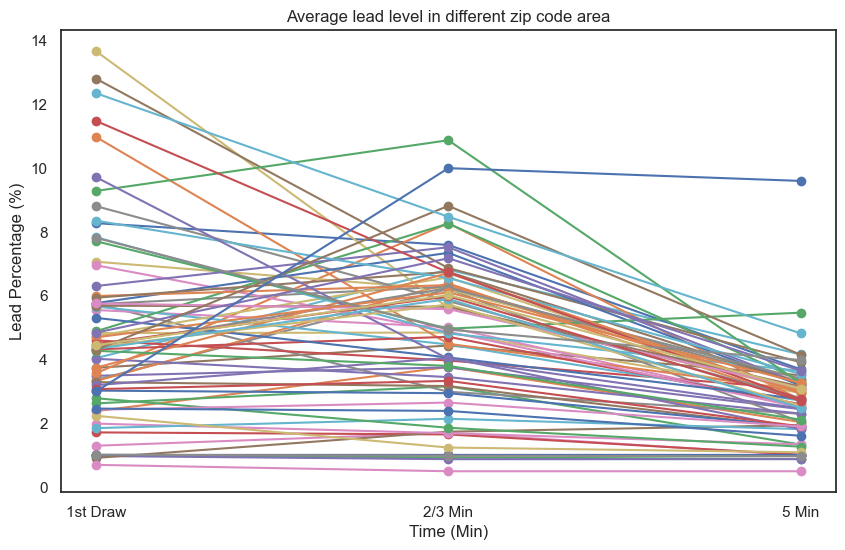

In [45]:
plt.figure(figsize=(10,6))

for i in range(71):
    plt.plot(['1st Draw', '2/3 Min', '5 Min'], zip_lead_df.iloc[i, 1:4], marker='o', label=zip_lead_df.iloc[i, 0])

plt.xlabel('Time (Min)')
plt.ylabel('Lead Percentage (%)')
plt.title('Average lead level in different zip code area')

plt.show()

In [46]:
time_graph_df = merged_df[['Sample Date', '2/3 Min', 'zip']]

Q1 = time_graph_df['2/3 Min'].quantile(0.25)
Q3 = time_graph_df['2/3 Min'].quantile(0.75)
IQR = Q3 - Q1

filter = (time_graph_df['2/3 Min'] >= Q1 - 5 * IQR) & (time_graph_df['2/3 Min'] <= Q3 + 5 *IQR)
time_graph_df = time_graph_df.loc[filter]

time_graph_df['Year'] = time_graph_df['Sample Date'].dt.year
time_graph_df = time_graph_df.groupby(['Year', 'zip'])['2/3 Min'].mean().reset_index()


time_graph_df

,Year,zip,2/3 Min
0,2016,46320,2.700000
1,2016,60068,1.940000
2,2016,60302,3.044000
3,2016,60406,2.900000
4,2016,60453,4.328571
...,...,...,...
544,2023,60712,5.568421
545,2023,60714,7.266667
546,2023,60804,5.244444
547,2023,60805,5.440000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


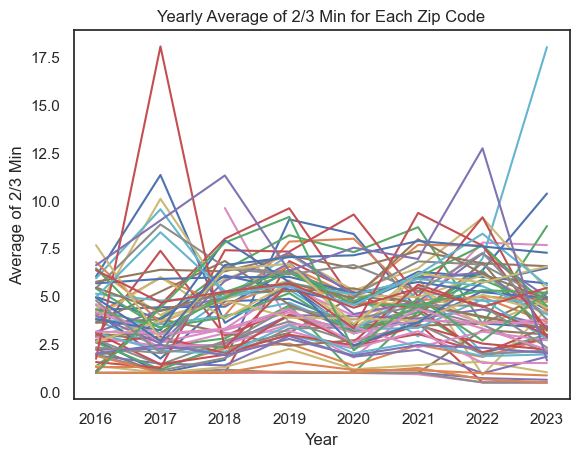

In [47]:
fig, ax = plt.subplots()
for name, group in time_graph_df.groupby('zip'):
    ax.plot(group['Year'], group['2/3 Min'],)
plt.legend().remove()
plt.title('Yearly Average of 2/3 Min for Each Zip Code')
plt.xlabel('Year')
plt.ylabel('Average of 2/3 Min')
plt.show()

D:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
D:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
D:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
D:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
D:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
D:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, 

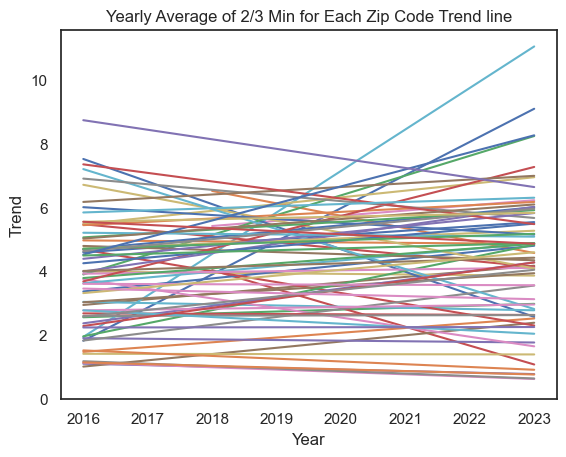

In [48]:
fig, ax = plt.subplots()
for name, group in time_graph_df.groupby('zip'):
    z = np.polyfit(group['Year'], group['2/3 Min'], 1)
    p = np.poly1d(z)
    ax.plot(group['Year'], p(group['Year']),)
plt.legend().remove()
plt.title('Yearly Average of 2/3 Min for Each Zip Code Trend line')
plt.xlabel('Year')
plt.ylabel('Trend')
plt.show()

In [49]:
population_df = zip_lead_df[['zip', '2/3 Min', 'population']]
population_df=population_df.sort_values(by=['population']).reset_index(drop=True)
population_df

,zip,2/3 Min,population
0,60602,1.654255,1142.0
1,60301,1.000000,2890.0
2,60606,1.739806,3298.0
3,60456,4.847414,4324.0
4,61834,10.000000,8247.0
...,...,...,...
66,60647,6.733994,85564.0
67,60632,4.818767,87395.0
68,60639,6.749444,89037.0
69,60618,5.019396,95078.0


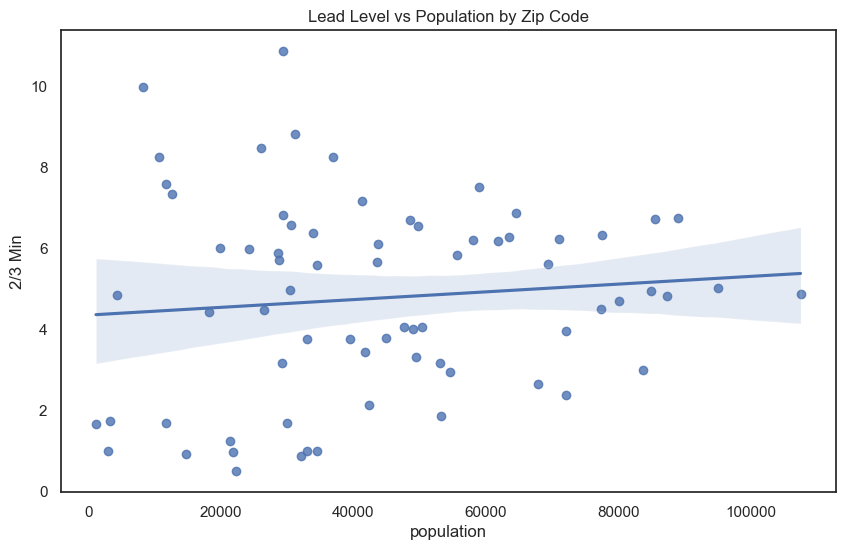

In [50]:
plt.figure(figsize=(10, 6))
sns.regplot(data=population_df, x='population', y='2/3 Min')
plt.title('Lead Level vs Population by Zip Code')
plt.show()

In [51]:
density_df = zip_lead_df[['zip', '2/3 Min', 'density']]
density_df = density_df.sort_values(by=['density']).reset_index(drop=True)
density_df

,zip,2/3 Min,density
0,61834,10.000000,29.8
1,60633,7.346195,502.0
2,60007,1.000000,704.7
3,60501,7.594565,1043.5
4,60803,0.500000,1111.7
...,...,...,...
66,60660,3.801048,13631.6
67,60601,0.931818,14706.9
68,60610,2.144706,14725.7
69,60654,0.985217,15577.5


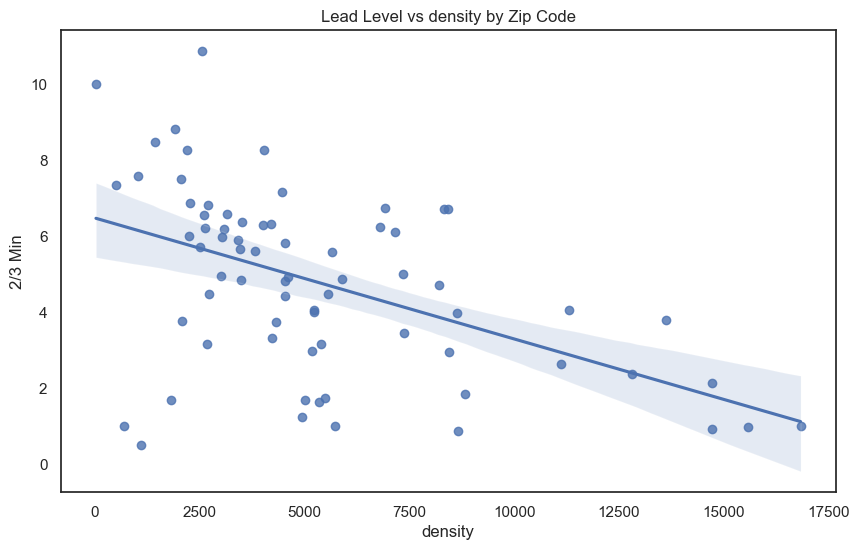

In [52]:
plt.figure(figsize=(10, 6))
sns.regplot(data=density_df, x='density', y='2/3 Min')
plt.title('Lead Level vs density by Zip Code')
plt.show()

In [53]:
detail_zip_df = merged_df.groupby('zip')[['1st Draw', '2/3 Min', '5 Min']].mean().reset_index()
zip_code_df = zip_code_df.rename(columns={'Name': 'zip'})

detail_zip_df = detail_zip_df.merge(zip_code_df[['zip','median_INC_2017-2021','per_capita_INC_2017-2021','major_crime_2018-2022','violent_crime_2018-2022','public_crime_2012-2016', 'behavioral_ health_hospitalizations_2017', 'cognitive_difficulty_percent_2017-2021', 'poverty_rate_percent_2017-2021','high_school_grad_rate_2017-2021', 'college_grad_rate_2017-2021', 'non_hispanic_white_percent_2017-2021']], on='zip', how='left')
detail_zip_df = detail_zip_df.dropna().reset_index(drop=1)
detail_zip_df = detail_zip_df.drop([14,44]).reset_index(drop=1)
detail_zip_df.to_csv('detail_zip.csv')
detail_zip_df.head()

,zip,1st Draw,2/3 Min,5 Min,median_INC_2017-2021,per_capita_INC_2017-2021,major_crime_2018-2022,violent_crime_2018-2022,public_crime_2012-2016,behavioral_ health_hospitalizations_2017,cognitive_difficulty_percent_2017-2021,poverty_rate_percent_2017-2021,high_school_grad_rate_2017-2021,college_grad_rate_2017-2021,non_hispanic_white_percent_2017-2021
0,60601,1.004545,0.931818,0.884848,123115.0,137556.0,1736.752366,148.889510,57.189159,91.0,1.995805,5.834093,97.917725,88.031149,54.877060
1,60602,1.717660,1.654255,1.021064,235666.0,168423.0,282.033895,25.289746,5.774626,25.0,0.000000,2.222222,100.000000,82.217782,47.022767
2,60605,0.977037,0.878519,0.878519,112162.0,85947.0,1675.218975,246.799483,126.443697,285.0,2.914663,8.612424,95.316371,78.088010,57.037753
3,60606,0.918447,1.739806,1.941748,130196.0,133605.0,529.774357,58.453847,20.751522,66.0,0.363857,8.550637,99.266177,91.794530,59.642207
4,60607,1.993191,1.692766,1.342979,109634.0,65052.0,2208.933790,266.924943,266.380039,651.0,4.155217,16.888971,96.620012,78.920985,51.797266


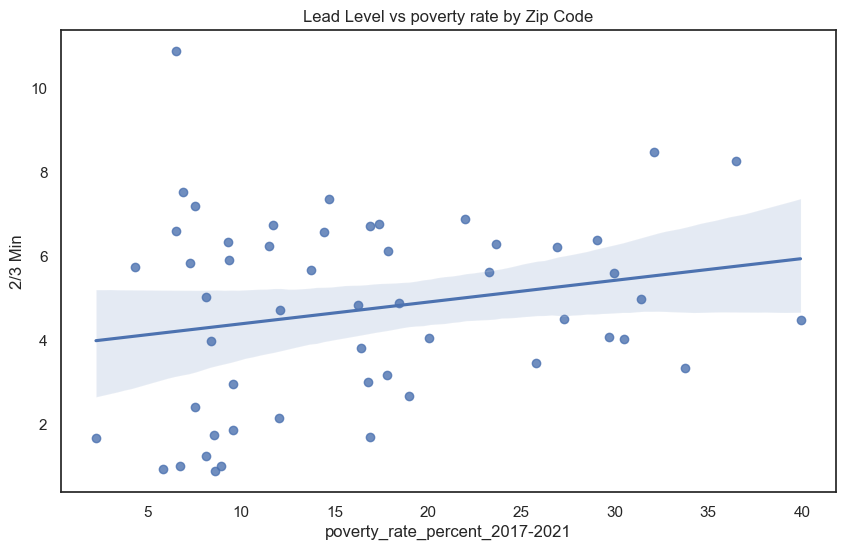

In [54]:
plt.figure(figsize=(10, 6))
sns.regplot(data=detail_zip_df, x='poverty_rate_percent_2017-2021', y='2/3 Min')
plt.title('Lead Level vs poverty rate by Zip Code')
plt.show()

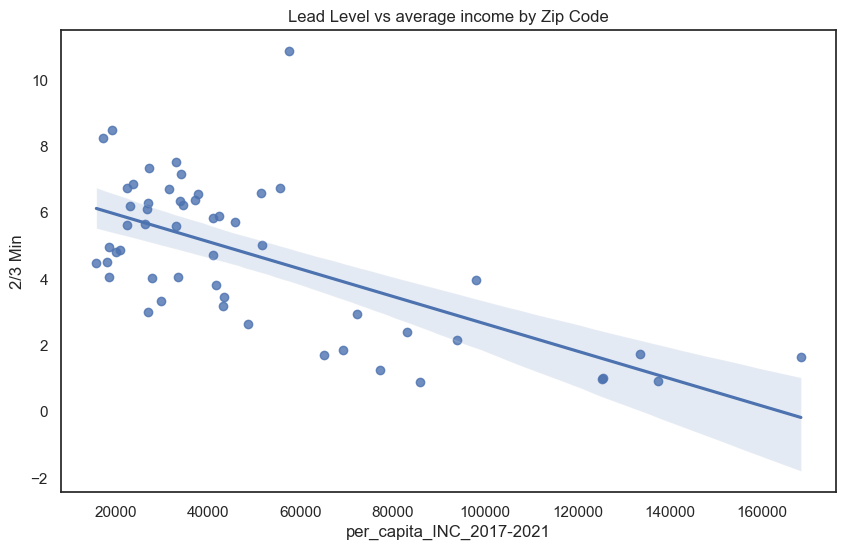

In [55]:
plt.figure(figsize=(10, 6))
sns.regplot(data=detail_zip_df, x='per_capita_INC_2017-2021', y='2/3 Min')
plt.title('Lead Level vs average income by Zip Code')
plt.show()

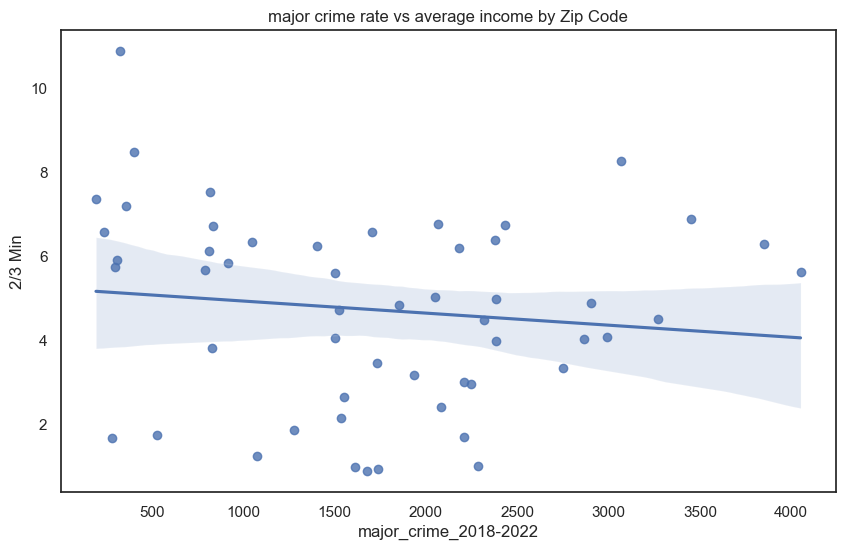

In [56]:
plt.figure(figsize=(10, 6))
sns.regplot(data=detail_zip_df, x='major_crime_2018-2022', y='2/3 Min')
plt.title('major crime rate vs average income by Zip Code')
plt.show()

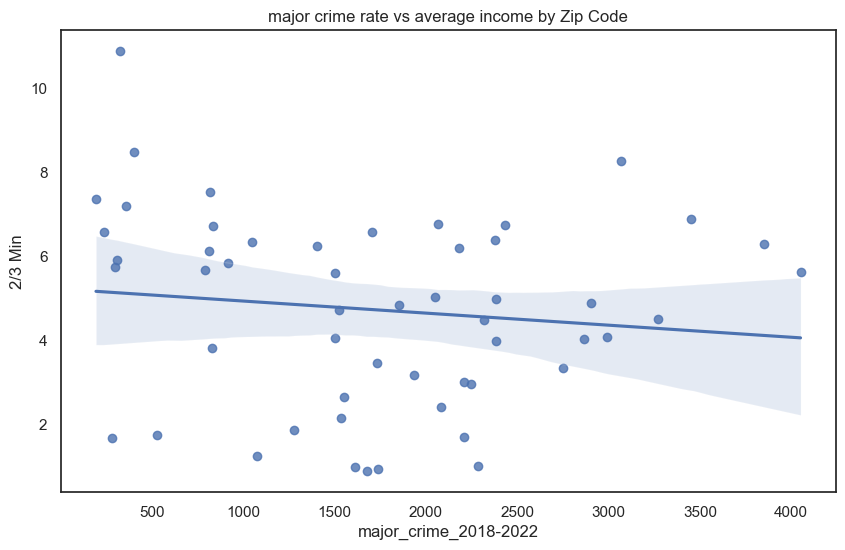

In [57]:
plt.figure(figsize=(10, 6))
sns.regplot(data=detail_zip_df, x='major_crime_2018-2022', y='2/3 Min')
plt.title('major crime rate vs average income by Zip Code')
plt.show()

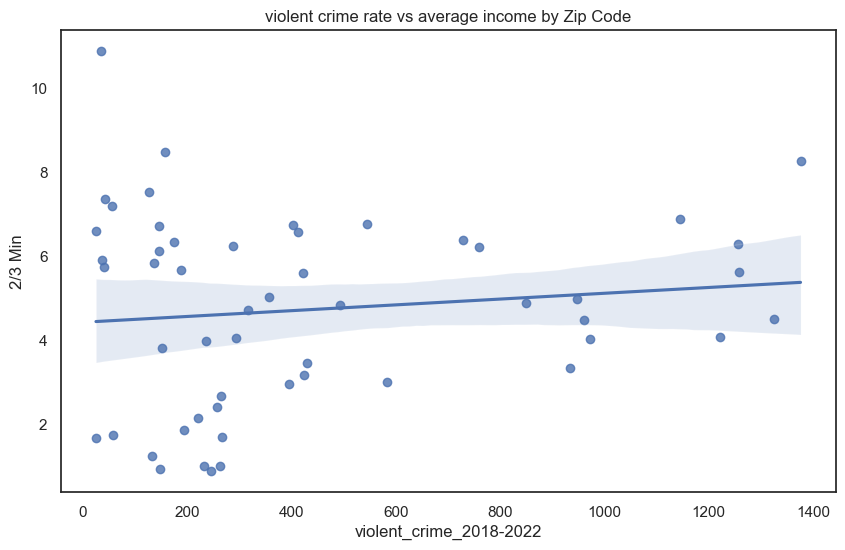

In [58]:
plt.figure(figsize=(10, 6))
sns.regplot(data=detail_zip_df, x='violent_crime_2018-2022', y='2/3 Min')
plt.title('violent crime rate vs average income by Zip Code')
plt.show()

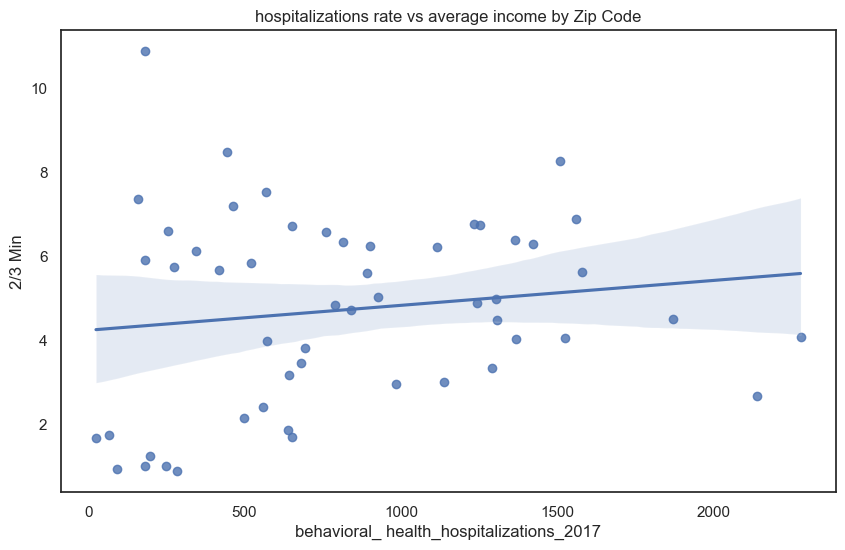

In [59]:
plt.figure(figsize=(10, 6))
sns.regplot(data=detail_zip_df, x='behavioral_ health_hospitalizations_2017', y='2/3 Min')
plt.title('hospitalizations rate vs average income by Zip Code')
plt.show()

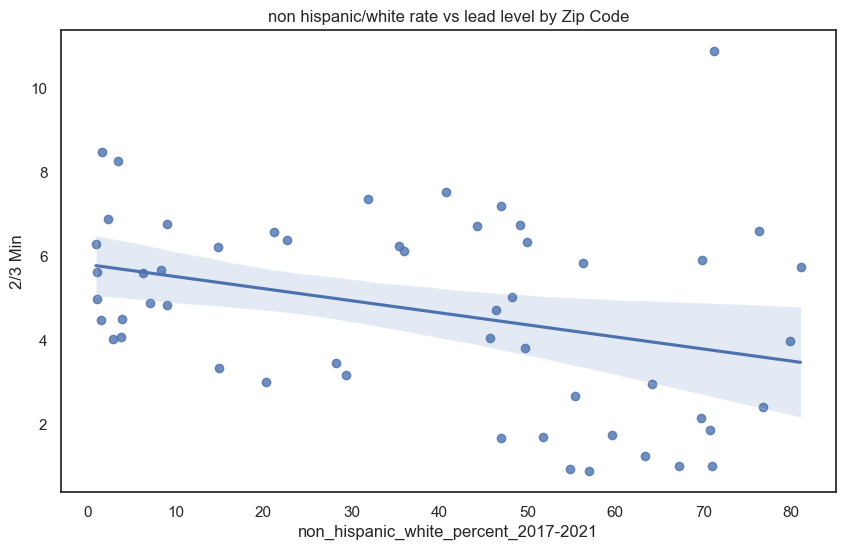

In [60]:

plt.figure(figsize=(10, 6))
sns.regplot(data=detail_zip_df, x='non_hispanic_white_percent_2017-2021', y='2/3 Min')
plt.title('non hispanic/white rate vs lead level by Zip Code')
plt.show()

In [61]:
merged_short_df = merged_df[['Sample Date', 'Address', '1st Draw', '2/3 Min', '5 Min', 'Lat GPS', 'Lon GPS', 'zip']]

In [62]:
merged_short_df.columns

Index(['Sample Date', 'Address', '1st Draw', '2/3 Min', '5 Min', 'Lat GPS',
       'Lon GPS', 'zip'],
      dtype='object')

In [63]:
merged_short_df.describe()

,1st Draw,2/3 Min,5 Min,Lat GPS,Lon GPS,zip
count,35636.000000,35636.000000,35636.00000,35636.000000,35636.000000,35636.000000
mean,6.551706,5.877865,4.49153,41.874588,-87.690151,60600.189668
std,89.861212,85.036219,293.05490,0.103259,0.059874,727.893420
min,0.500000,0.500000,0.50000,40.194334,-87.957020,46320.000000
25%,1.000000,1.000000,1.00000,41.777412,-87.728550,60620.000000
50%,2.200000,2.400000,1.40000,41.914791,-87.682660,60636.000000
75%,4.200000,6.200000,2.90000,41.960264,-87.652394,60647.000000
max,10000.000000,13000.000000,55000.00000,42.022108,-87.528170,61834.000000


In [64]:
# convert it to numeric first
merged_short_df['5 Min'] = pd.to_numeric(merged_short_df['5 Min'], errors='coerce')
# Sort the DataFrame by '5 Min' column in descending order
sorted_df = merged_short_df.sort_values(by='5 Min', ascending=False)

sorted_df.head(60)

C:\Users\T\AppData\Local\Temp\ipykernel_26416\900763518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_short_df['5 Min'] = pd.to_numeric(merged_short_df['5 Min'], errors='coerce')


,Sample Date,Address,1st Draw,2/3 Min,5 Min,Lat GPS,Lon GPS,zip
31971,2022-09-21 08:00:00,3500 W THOMAS ST,10000.0,13000.0,55000.0,41.902058,-87.713810,60651
24558,2020-12-10 00:00:00,9700 S MERRION AVE,390.0,8000.0,5800.0,41.718342,-87.574012,60617
36256,2023-06-15 07:41:00,5800 S CAMPBELL AVE,200.0,110.0,720.0,41.784162,-87.689244,60636
36255,2023-06-15 07:41:00,5800 S CAMPBELL AVE,200.0,110.0,720.0,41.784162,-87.689244,60636
36134,2023-06-07 18:00:00,3000 W FULLERTON AVE,1400.0,2700.0,420.0,41.925704,-87.701527,60647
36133,2023-06-07 18:00:00,3000 W FULLERTON AVE,1400.0,2700.0,420.0,41.925704,-87.701527,60647
10170,2019-03-31 00:00:00,6900 N TONTY AVE,2.0,460.0,240.0,42.007556,-87.778912,60714
31647,2022-08-31 06:00:00,1500 S HAMLIN AVE,240.0,210.0,180.0,41.856734,-87.721180,60623
35822,2023-05-19 06:15:00,12000 S PRINCETON AVE,140.0,170.0,180.0,41.679524,-87.635197,60628
25860,2021-06-28 00:00:00,4800 S KEELER AVE,2.6,2.8,170.0,41.801040,-87.731007,60632


tweak the data to remove outliers:  
cutoff limit = mean+15  
if value > limit then value = limit

In [65]:
columns_to_process = ['1st Draw', '2/3 Min', '5 Min']
# Iterate through the columns
for column in columns_to_process:
    # Calculate the mean
    column_mean = merged_short_df[column].mean()
    # Set the limit value
    limit_value = column_mean + 15
    # Replace values greater than the limit with the limit value
    merged_short_df[column] = merged_short_df[column].where(merged_short_df[column] <= limit_value, limit_value)

merged_short_df.describe()

C:\Users\T\AppData\Local\Temp\ipykernel_26416\487401734.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_short_df[column] = merged_short_df[column].where(merged_short_df[column] <= limit_value, limit_value)


,1st Draw,2/3 Min,5 Min,Lat GPS,Lon GPS,zip
count,35636.000000,35636.000000,35636.000000,35636.000000,35636.000000,35636.000000
mean,3.565901,4.573882,2.588065,41.874588,-87.690151,60600.189668
std,4.121460,5.102081,3.119328,0.103259,0.059874,727.893420
min,0.500000,0.500000,0.500000,40.194334,-87.957020,46320.000000
25%,1.000000,1.000000,1.000000,41.777412,-87.728550,60620.000000
50%,2.200000,2.400000,1.400000,41.914791,-87.682660,60636.000000
75%,4.200000,6.200000,2.900000,41.960264,-87.652394,60647.000000
max,21.551706,20.877865,19.491530,42.022108,-87.528170,61834.000000


In [66]:
merged_short_df.iloc[20000:20060]

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Lat GPS,Lon GPS,zip
21191,2019-12-26,8200 S MORGAN ST,3.800000,1.3,1.1,41.743657,-87.652394,60620
21192,2019-12-26,1500 N CLEVELAND AVE,1.000000,1.0,1.0,41.909334,-87.640111,60610
21193,2019-12-26,600 W WILLOW ST,1.000000,1.0,1.0,41.913699,-87.642567,60614
21194,2019-12-26,10700 S MAPLEWOOD AVE,3.200000,9.7,1.9,41.701464,-87.690030,60655
21195,2019-12-26,2100 W CORTEZ ST,1.000000,1.0,1.0,41.900821,-87.679417,60622
21196,2019-12-26,3300 W 114TH ST,3.900000,2.6,1.2,41.689650,-87.708897,60655
21197,2019-12-26,1100 N MARSHFIELD AVE,1.700000,1.0,1.0,41.902058,-87.667920,60622
21198,2019-12-26,8000 S MOZART ST,4.100000,4.4,4.3,41.747033,-87.697400,60652
21199,2019-12-26,500 W 97TH ST,7.000000,1.5,1.1,41.718342,-87.640111,60620
21200,2019-12-26,2700 W GREGORY ST,5.900000,18.0,2.3,41.982637,-87.694157,60659


In [67]:
# Group by 'zip' and calculate the mean for each group
grouped_df = merged_short_df.groupby('zip').mean(numeric_only=True).reset_index()

In [68]:
grouped_df.describe()

,zip,1st Draw,2/3 Min,5 Min,Lat GPS,Lon GPS
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,60418.552632,3.429403,4.422765,2.579408,41.836976,-87.699241
std,1651.675234,1.376759,2.079815,1.229173,0.217118,0.076096
min,46320.000000,0.700000,0.500000,0.500000,40.194334,-87.957020
25%,60607.750000,2.610698,2.966449,1.879674,41.779509,-87.757168
50%,60627.000000,3.724078,4.599912,2.689175,41.881153,-87.695840
75%,60647.500000,4.149177,5.900144,3.077062,41.945725,-87.649829
max,61834.000000,7.662642,10.000000,9.600000,42.015103,-87.536846


In [69]:
gdf2 = gpd.read_file("boundaries-zipcode.geojson")

C:\Users\T\AppData\Local\Temp\ipykernel_26416\2575441856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_short_df['zip'] = merged_short_df['zip'].astype(str)


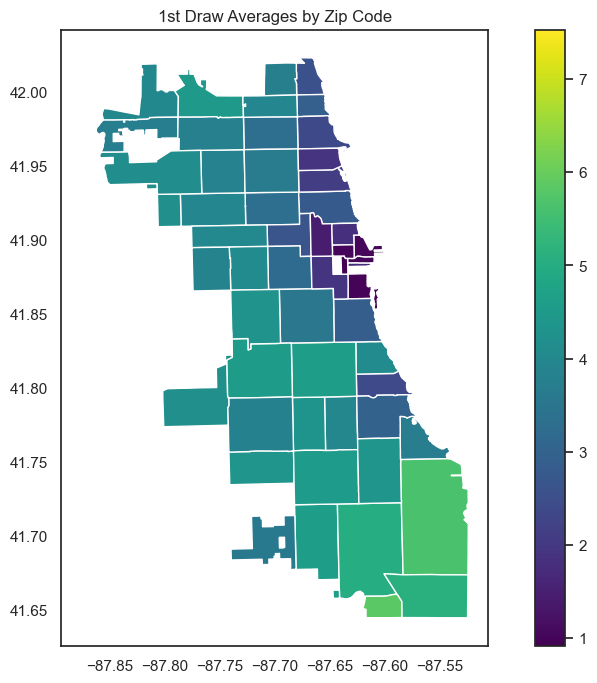

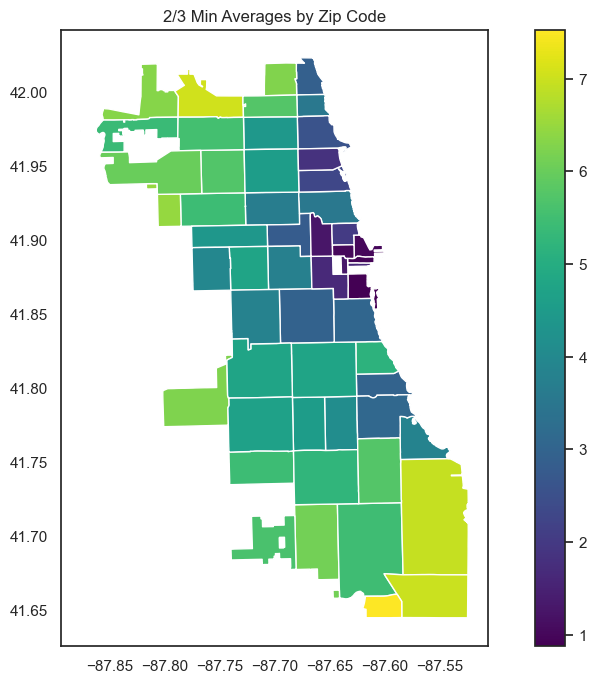

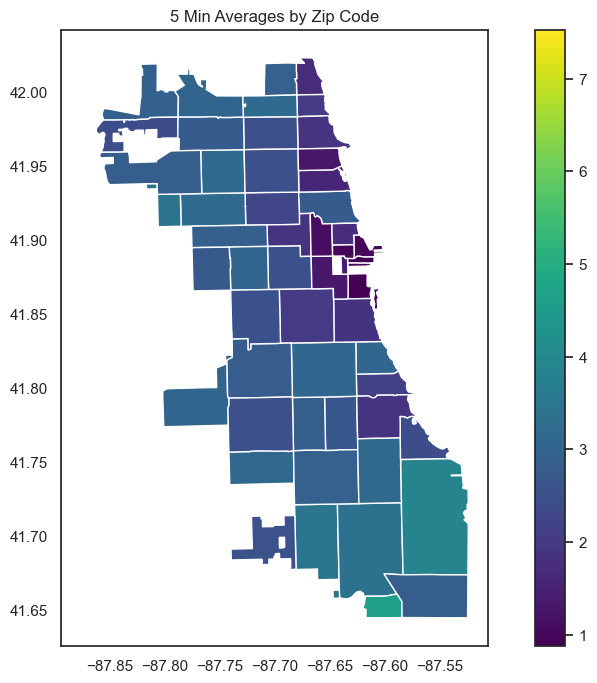

In [70]:
# Convert 'zip' column to string type in both DataFrames
gdf2['zip'] = gdf2['zip'].astype(str)
merged_short_df['zip'] = merged_short_df['zip'].astype(str)
# Group by 'zip' and calculate mean for '1st Draw', '2/3 Min', '5 Min'
grouped_df = merged_short_df.groupby('zip').agg({
    '1st Draw': 'mean',
    '2/3 Min': 'mean',
    '5 Min': 'mean'
}).reset_index()
# Merge GeoPandas DataFrame with the grouped averages
merged_gdf = gdf2.merge(grouped_df, on='zip', how='left')
# Find the maximum value among the three columns
max_value = merged_gdf[['1st Draw', '2/3 Min', '5 Min']].max().max()
# Plott the heatmap for '1st Draw'
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='1st Draw', ax=ax, legend=True, cmap='viridis', vmax=max_value)
ax.set_title('1st Draw Averages by Zip Code')
plt.show()
# Plot the heatmap for '2/3 Min'
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='2/3 Min', ax=ax, legend=True, cmap='viridis', vmax=max_value)
ax.set_title('2/3 Min Averages by Zip Code')
plt.show()
# Plot the heatmap for '5 Min'
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='5 Min', ax=ax, legend=True, cmap='viridis', vmax=max_value)
ax.set_title('5 Min Averages by Zip Code')
plt.show()

# ML Model 1

### The correlation coefficient ranges from -1 to 1, with 1 indicating a perfect positive correlation, -1 indicating a perfect negative correlation, and 0 indicating no correlation.

In [71]:
correlations = detail_zip_df.corr()['violent_crime_2018-2022'].sort_values(ascending=False)

# Display correlations
print(correlations)

violent_crime_2018-2022                     1.000000
public_crime_2012-2016                      0.981617
major_crime_2018-2022                       0.885142
behavioral_ health_hospitalizations_2017    0.805522
poverty_rate_percent_2017-2021              0.759483
cognitive_difficulty_percent_2017-2021      0.743328
1st Draw                                    0.442980
5 Min                                       0.302114
2/3 Min                                     0.120566
zip                                        -0.186660
per_capita_INC_2017-2021                   -0.481544
high_school_grad_rate_2017-2021            -0.522439
college_grad_rate_2017-2021                -0.559589
median_INC_2017-2021                       -0.615692
non_hispanic_white_percent_2017-2021       -0.758345
Name: violent_crime_2018-2022, dtype: float64


In [72]:
correlations = detail_zip_df.corr()['1st Draw'].sort_values(ascending=False)

# Display correlations
print(correlations)

1st Draw                                    1.000000
5 Min                                       0.709906
2/3 Min                                     0.652188
public_crime_2012-2016                      0.508772
violent_crime_2018-2022                     0.442980
cognitive_difficulty_percent_2017-2021      0.401813
behavioral_ health_hospitalizations_2017    0.393259
poverty_rate_percent_2017-2021              0.358871
zip                                         0.357431
major_crime_2018-2022                       0.301543
high_school_grad_rate_2017-2021            -0.456891
median_INC_2017-2021                       -0.508832
non_hispanic_white_percent_2017-2021       -0.558374
per_capita_INC_2017-2021                   -0.604502
college_grad_rate_2017-2021                -0.665854
Name: 1st Draw, dtype: float64


In [73]:
correlations = detail_zip_df.corr()['per_capita_INC_2017-2021'].sort_values(ascending=False)

# Display correlations
print(correlations)

per_capita_INC_2017-2021                    1.000000
median_INC_2017-2021                        0.891999
college_grad_rate_2017-2021                 0.881410
high_school_grad_rate_2017-2021             0.735185
non_hispanic_white_percent_2017-2021        0.654809
major_crime_2018-2022                      -0.246573
zip                                        -0.297165
violent_crime_2018-2022                    -0.481544
public_crime_2012-2016                     -0.531061
behavioral_ health_hospitalizations_2017   -0.576418
1st Draw                                   -0.604502
poverty_rate_percent_2017-2021             -0.615352
2/3 Min                                    -0.650068
5 Min                                      -0.696811
cognitive_difficulty_percent_2017-2021     -0.708160
Name: per_capita_INC_2017-2021, dtype: float64


In [74]:
# Select features and target variable
features = detail_zip_df[['1st Draw']]  # Selecting '1st Draw' as the only feature
target = detail_zip_df['violent_crime_2018-2022']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=43)

# Initialize Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Visualize the predicted vs actual values
plt.scatter(X_test, y_test, label='Actual Values', s=10)
plt.scatter(X_test, predictions, label='Predicted Values', s=10)
plt.plot(X_test, predictions, color='red', linewidth=0.1, label='Regression Line')
plt.xlabel('1st Draw')
plt.ylabel('Violent Crime count')
plt.title('Actual vs Predicted Violent Crime count based on 1st draw')
plt.legend()
plt.show()


NameError: name 'train_test_split' is not defined

In [77]:
# Select features and target variable
features = detail_zip_df[['per_capita_INC_2017-2021']]  # Selecting 'per_capita_INC_2017-2021' as the feature
target = detail_zip_df['1st Draw']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=40)

# Initialize Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Visualize the predicted vs actual values with regression line
plt.scatter(X_test, y_test, label='Actual Values', s=10)
plt.scatter(X_test, predictions, label='Predicted Values', s=12)
plt.plot(X_test, predictions, color='red', linewidth=0.1, label='Regression Line')
plt.xlabel('Per Capita income')
plt.ylabel('1st Draw')
plt.title('Actual vs Predicted 1st Draw based on Per Capita income')
plt.legend()
plt.show()


NameError: name 'train_test_split' is not defined

# ML Model 2

Using the Elbow Method we can make an informed decision about the appropriate number of clusters for our dataset based on the trade-off between model complexity and performance.  
  
The optimal number of clusters (K) is often chosen at the point where the inertia starts to level off, forming an elbow shape. The goal is to find a balance between having enough clusters to represent the data well and not having too many clusters that result in over-segmentation.

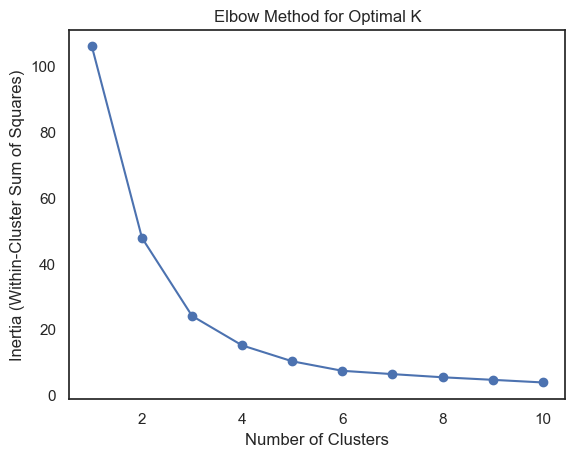

In [80]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# Select features for clustering
cluster_features = detail_zip_df[['1st Draw', 'per_capita_INC_2017-2021']]
# Standardize the features
scaler = StandardScaler()
cluster_features_standardized = scaler.fit_transform(cluster_features)
# Determine the optimal number of clusters using the Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_features_standardized)
    inertia.append(kmeans.inertia_)
# Plot the Elbow method
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

3 looks like the optimal number of clusters 

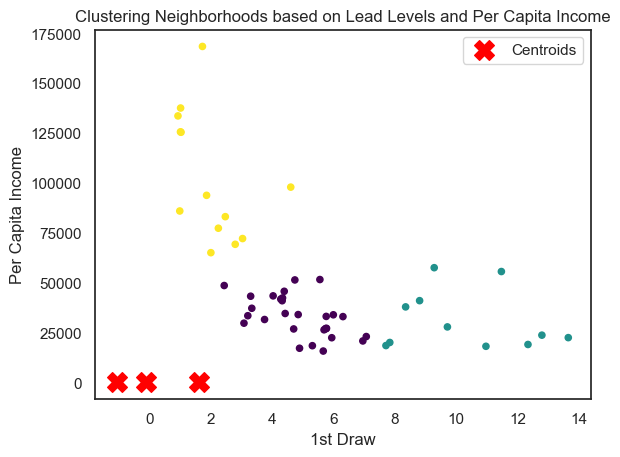

In [81]:
# Based on the Elbow method, let's say the optimal number of clusters is 3
k = 3
# Apply K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(cluster_features_standardized)
# Add the cluster labels to the original dataframe
detail_zip_df['lead_level_cluster'] = clusters
# Visualize the clusters
plt.scatter(detail_zip_df['1st Draw'], detail_zip_df['per_capita_INC_2017-2021'], c=clusters, cmap='viridis', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=200, c='red', label='Centroids')
plt.xlabel('1st Draw')
plt.ylabel('Per Capita Income')
plt.title('Clustering Neighborhoods based on Lead Levels and Per Capita Income')
plt.legend()
plt.show()

From the results and the visualization of the clustered data, it appears that there is a correlation between higher income areas and lower lead levels. However, this correlation does not imply causation. Further testing and exploration of other relevant features could provide a better understanding of the factors influencing lead levels in different neighborhoods.

Now we compare the baseline distribution of the clusters

In [86]:
# Display the distribution of clusters
print(detail_zip_df['lead_level_cluster'].value_counts())

# Baseline comparison
baseline_percentage = detail_zip_df['lead_level_cluster'].value_counts() / len(detail_zip_df)
print('\nBaseline Distribution:')
print(baseline_percentage)


0    29
2    13
1    11
Name: lead_level_cluster, dtype: int64

Baseline Distribution:
0    0.547170
2    0.245283
1    0.207547
Name: lead_level_cluster, dtype: float64


Analyze the characteristics of each cluster

In [87]:
# Group the data by cluster and calculate mean values for each cluster
cluster_means = detail_zip_df.groupby('lead_level_cluster').mean()
# Display the characteristics of each cluster
print(cluster_means)

                             zip   1st Draw   2/3 Min     5 Min  \
lead_level_cluster                                                
0                   60636.068966   4.878788  5.426611  2.765459   
1                   60652.818182  10.270856  6.297780  3.525237   
2                   60618.769231   1.969234  1.803266  1.446864   

                    median_INC_2017-2021  per_capita_INC_2017-2021  \
lead_level_cluster                                                   
0                           59654.586207              33149.034483   
1                           56501.181818              31063.272727   
2                          123589.538462             102701.307692   

                    major_crime_2018-2022  violent_crime_2018-2022  \
lead_level_cluster                                                   
0                             1600.915059               453.564517   
1                             2150.373436               662.687569   
2                             160

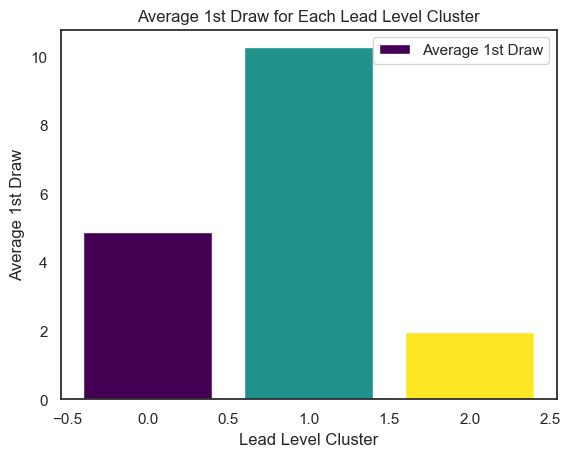

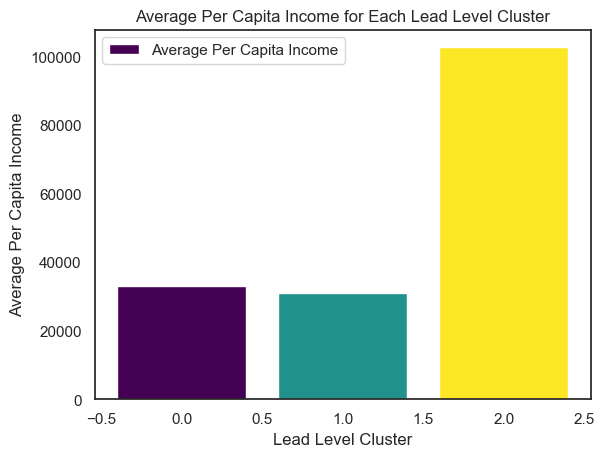

In [89]:

# Group the data by cluster and calculate mean values for each cluster
cluster_means = detail_zip_df.groupby('lead_level_cluster').mean()

# Get unique colors based on the number of clusters
unique_colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_means)))

# Plot the average '1st Draw' values for each cluster
plt.bar(cluster_means.index, cluster_means['1st Draw'], color=unique_colors, label='Average 1st Draw')
plt.xlabel('Lead Level Cluster')
plt.ylabel('Average 1st Draw')
plt.title('Average 1st Draw for Each Lead Level Cluster')
plt.legend()
plt.show()

# Plot the average 'per_capita_INC_2017-2021' values for each cluster
plt.bar(cluster_means.index, cluster_means['per_capita_INC_2017-2021'], color=unique_colors, label='Average Per Capita Income')
plt.xlabel('Lead Level Cluster')
plt.ylabel('Average Per Capita Income')
plt.title('Average Per Capita Income for Each Lead Level Cluster')
plt.legend()
plt.show()



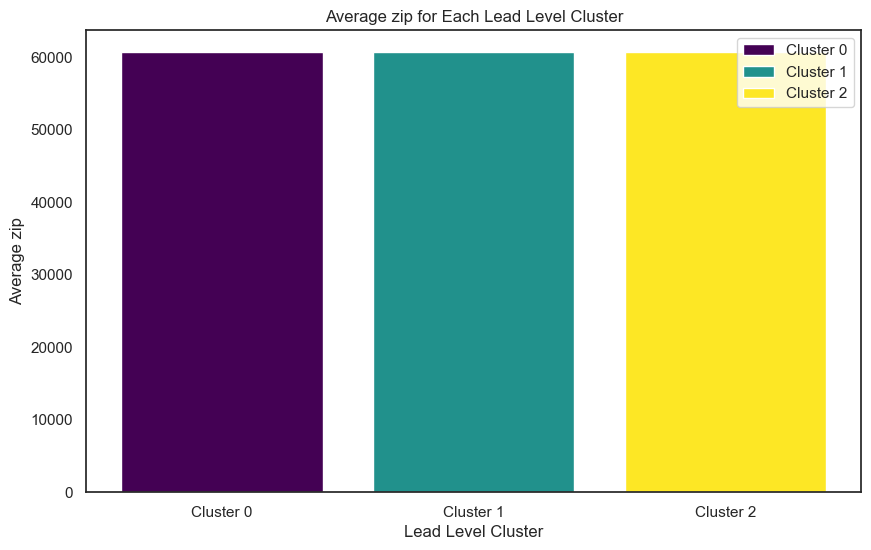

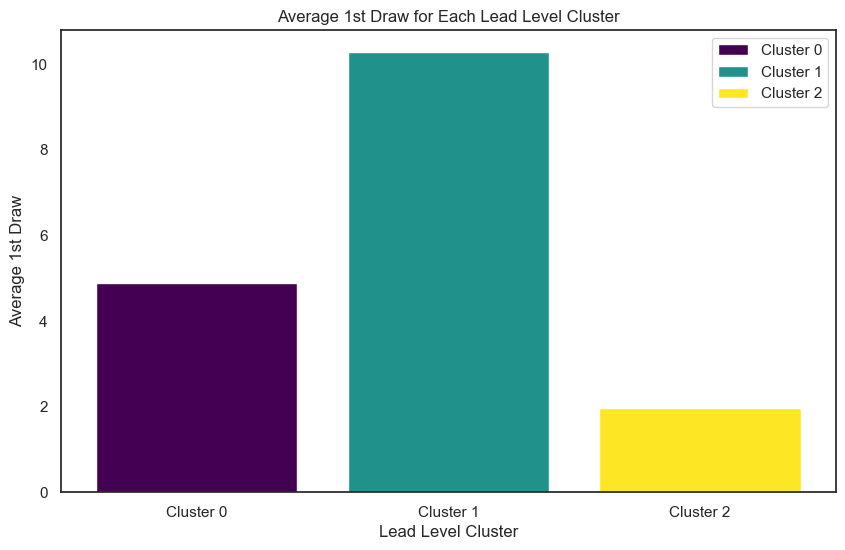

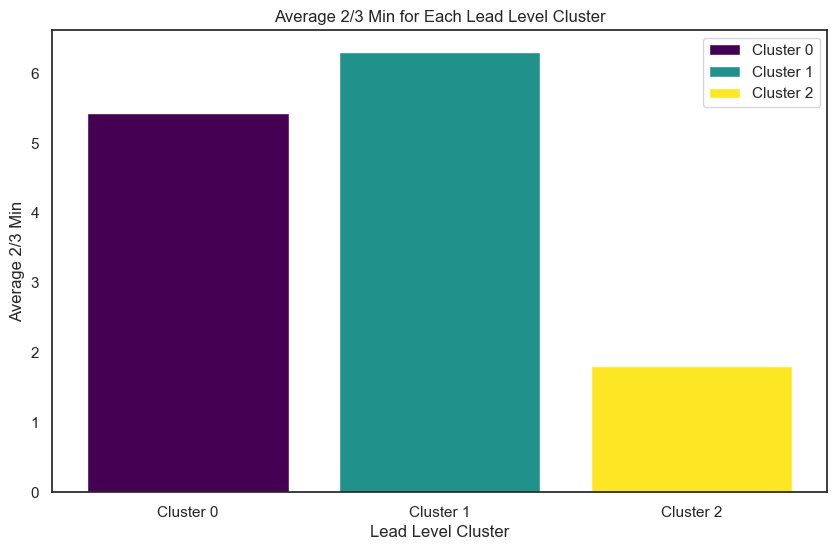

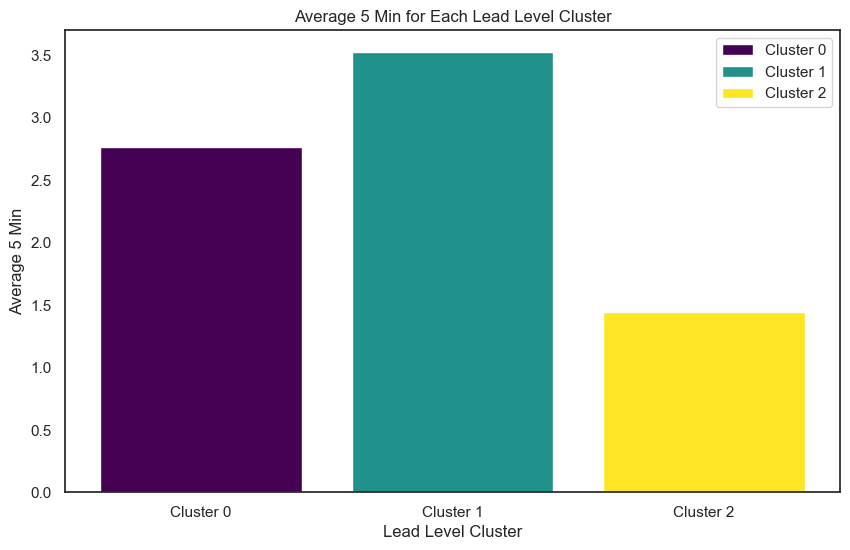

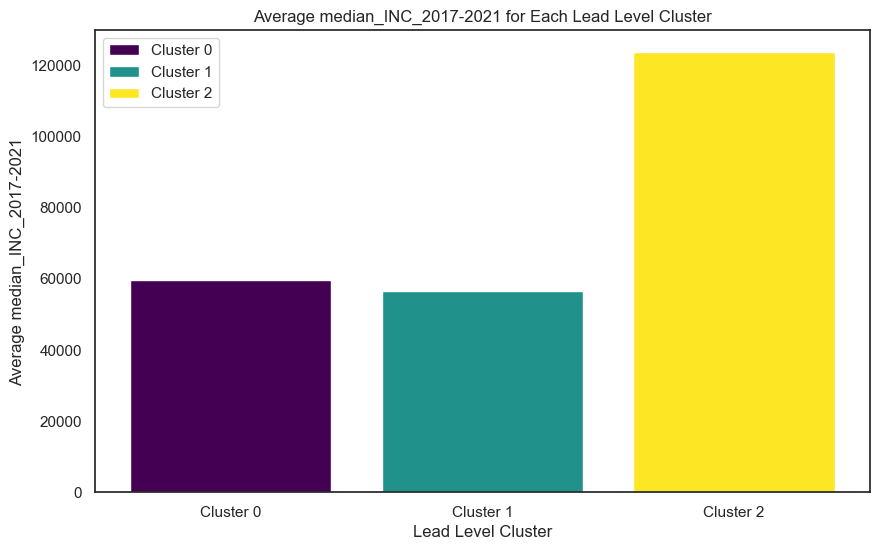

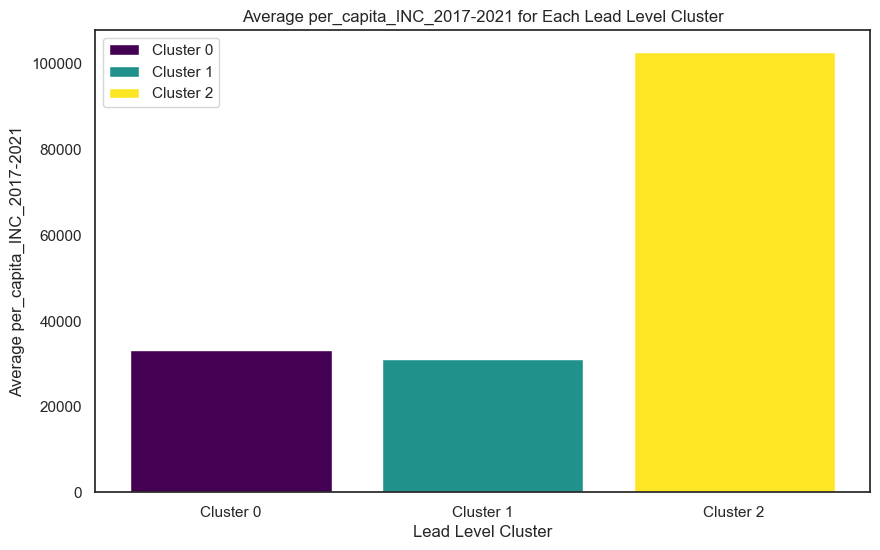

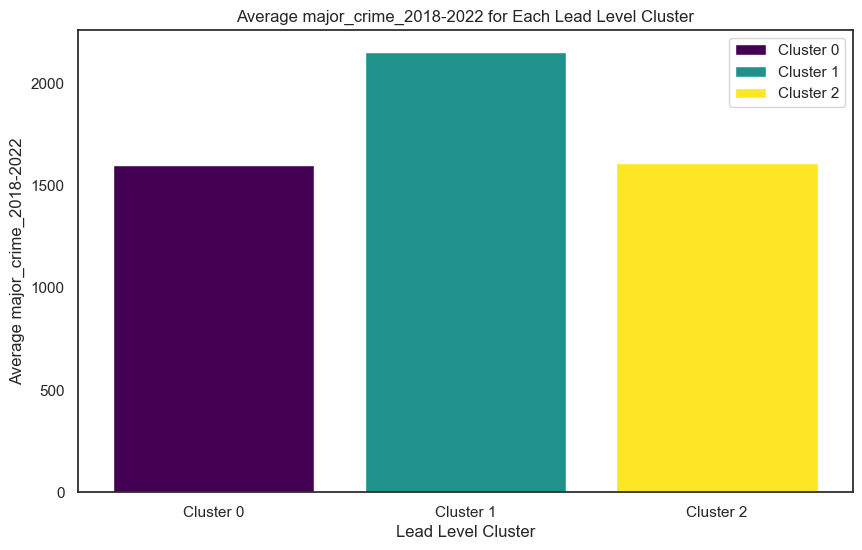

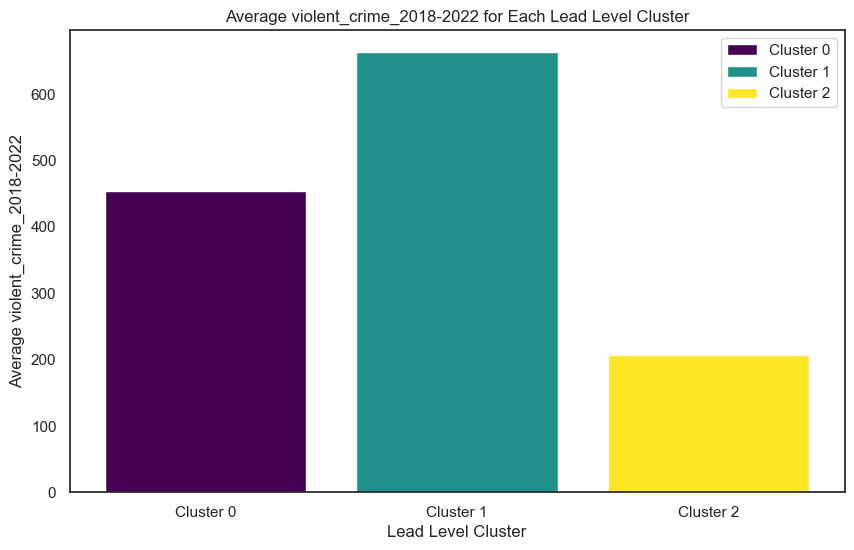

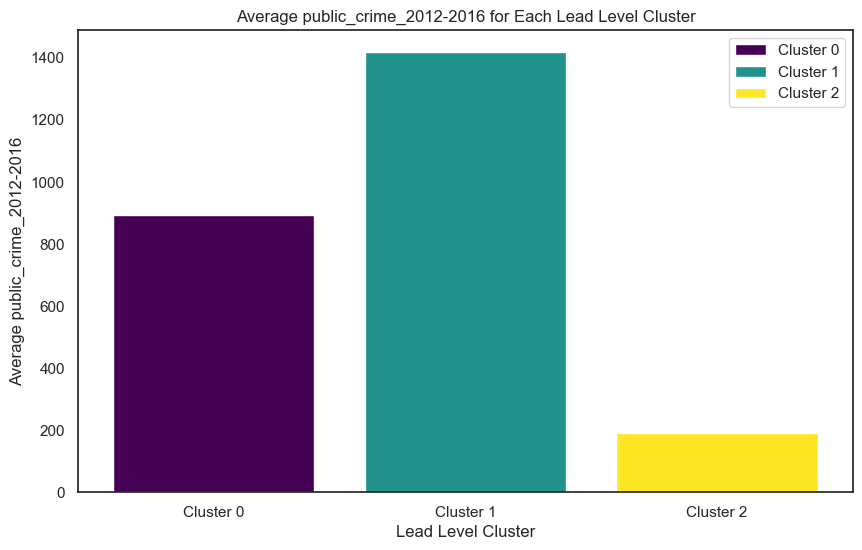

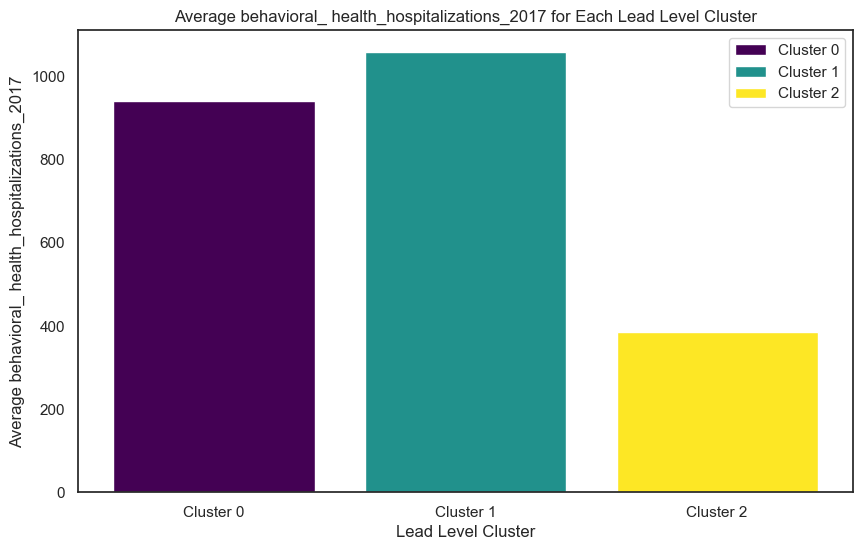

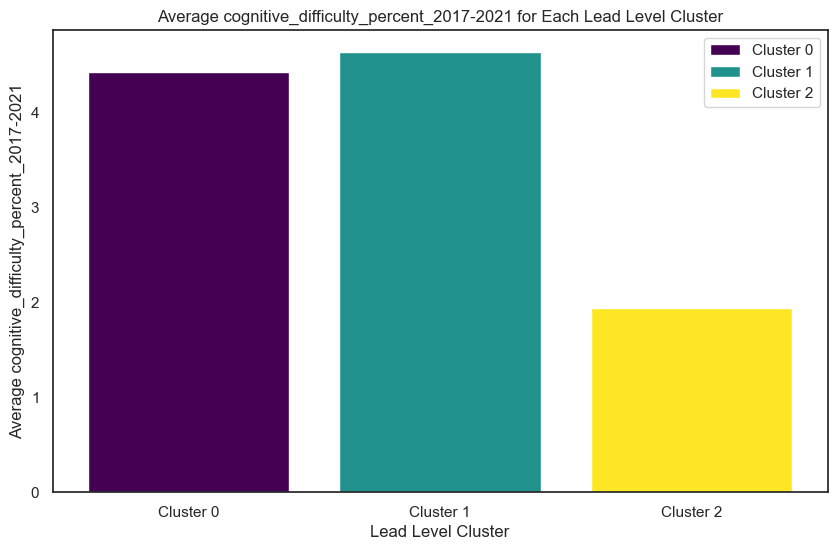

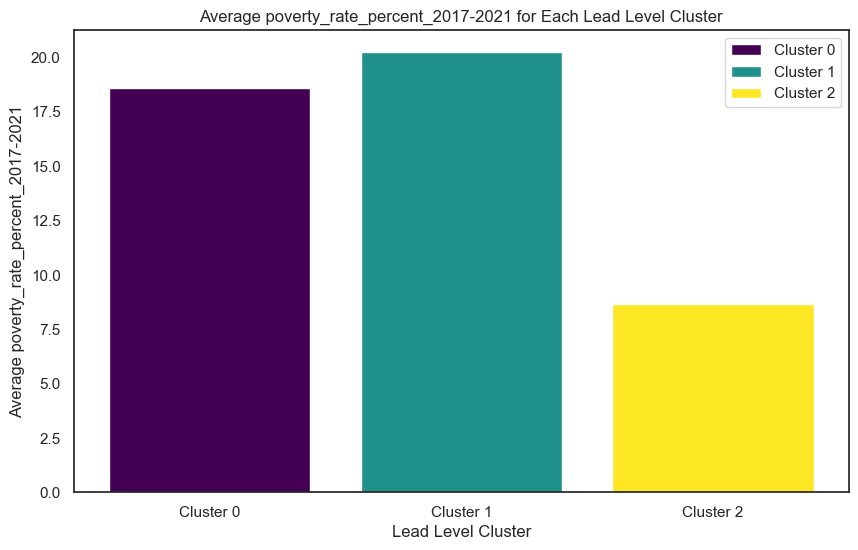

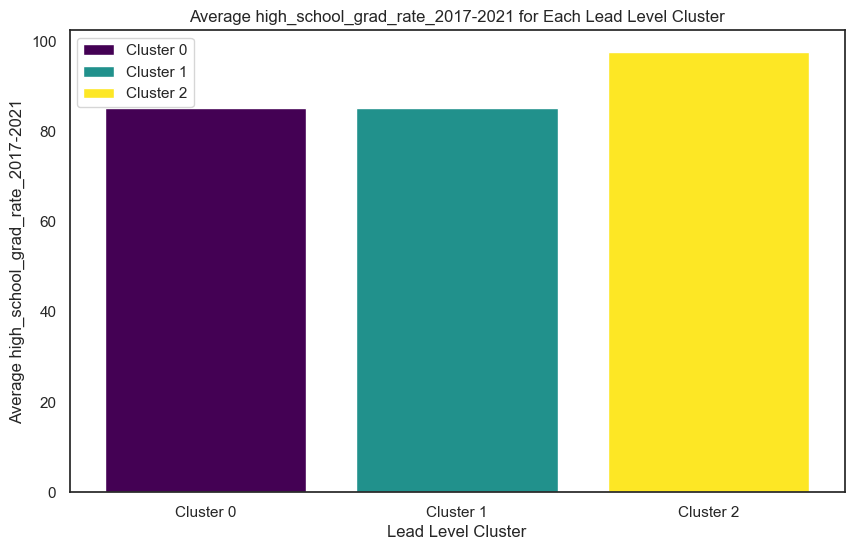

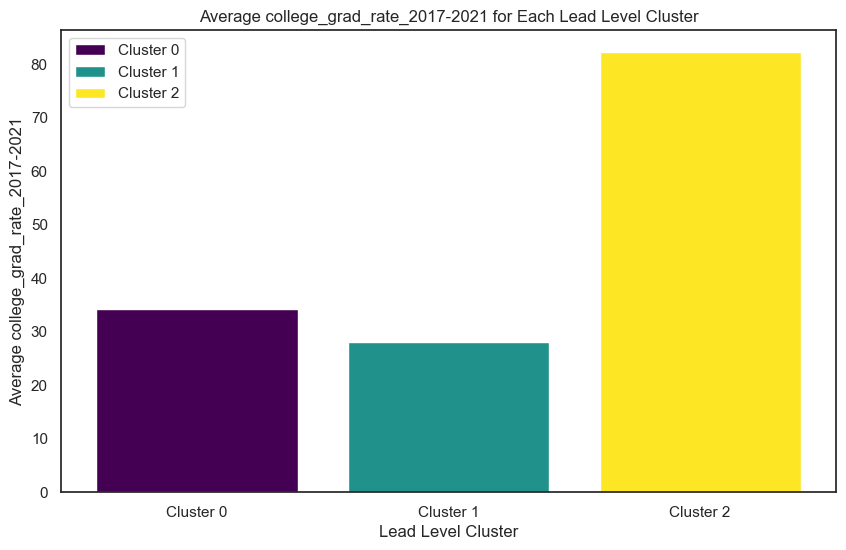

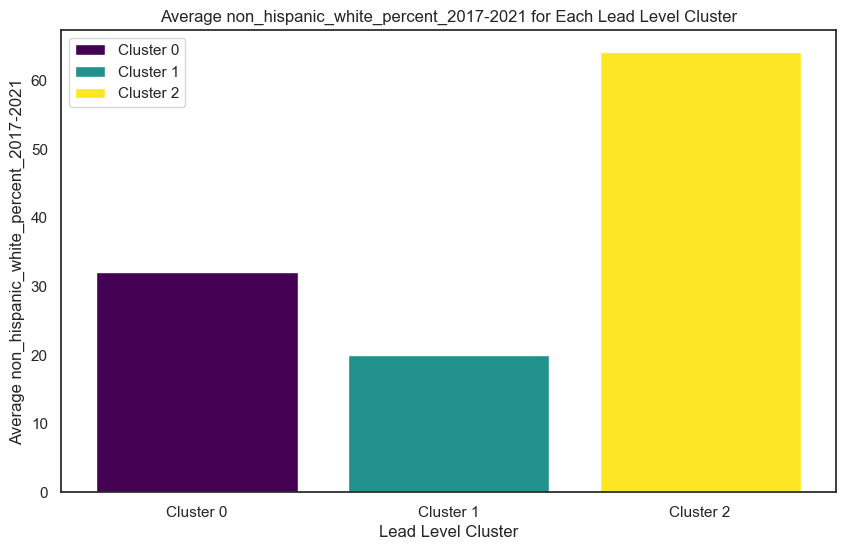

In [90]:
# Group the data by cluster and calculate mean values for each cluster
cluster_means = detail_zip_df.groupby('lead_level_cluster').mean()
# Get unique colors based on the number of clusters
unique_colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_means)))
# List of features to analyze
features_to_analyze = [
    'zip',
    '1st Draw',
    '2/3 Min',
    '5 Min',
    'median_INC_2017-2021',
    'per_capita_INC_2017-2021',
    'major_crime_2018-2022',
    'violent_crime_2018-2022',
    'public_crime_2012-2016',
    'behavioral_ health_hospitalizations_2017',
    'cognitive_difficulty_percent_2017-2021',
    'poverty_rate_percent_2017-2021',
    'high_school_grad_rate_2017-2021',
    'college_grad_rate_2017-2021',
    'non_hispanic_white_percent_2017-2021'
]
# Plot each feature for each cluster
for feature in features_to_analyze:
    plt.figure(figsize=(10, 6))
    for i, (cluster, color) in enumerate(zip(cluster_means.index, unique_colors), 1):
        plt.bar(i, cluster_means.loc[cluster, feature], color=color, label=f'Cluster {cluster}')

    plt.xlabel('Lead Level Cluster')
    plt.ylabel(f'Average {feature}')
    plt.title(f'Average {feature} for Each Lead Level Cluster')
    plt.xticks(range(1, len(cluster_means) + 1), [f'Cluster {cluster}' for cluster in cluster_means.index])
    plt.legend()
    plt.show()
